# DSFB Assignment 4 - SOLUTIONS

# **PART 1**: Decision Trees

Unlike a logit model or a KNN classifier, decision trees are not sensitive to the scaling of categorical features and numeric features. They can find a cut point in arbitrary numeric or categorical features. The implementation of decision trees in sklearn, however, does require categorical features to be one-hot-encoded, even though that is technically not required by the algorithm.

For this part of the assignment, we  return to the problem of trying to predict the probability of defaulting on a credit card account at a Taiwanese bank. A credit card default happens when a customer fails to pay the minimum due on a credit card bill for more than 6 months. 

We will use a dataset from a Taiwanese bank with 30,000 observations (Source: *Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.*). Each observation represents an account at the bank at the end of October 2005.  We renamed the variable default_payment_next_month to customer_default. The target variable to predict is `customer_default` -- i.e., whether the customer will default in the following month (1 = Yes or 0 = No). The dataset also includes 23 other explanatory features. 

Variables are defined as follows:

| Feature name     | Variable Type | Description 
|------------------|---------------|--------------------------------------------------------
| customer_default | Binary        | 1 = default in following month; 0 = no default 
| LIMIT_BAL        | Continuous    | Credit limit   
| SEX              | Categorical   | 1 = male; 2 = female
| EDUCATION        | Categorical   | 1 = graduate school; 2 = university; 3 = high school; 4 = others
| MARRIAGE         | Categorical   | 0 = unknown; 1 = married; 2 = single; 3 = others
| AGE              | Continuous    | Age in years  
| PAY1             | Categorical   | Repayment status in September, 2005 
| PAY2             | Categorical   | Repayment status in August, 2005 
| PAY3             | Categorical   | Repayment status in July, 2005 
| PAY4             | Categorical   | Repayment status in June, 2005 
| PAY5             | Categorical   | Repayment status in May, 2005 
| PAY6             | Categorical   | Repayment status in April, 2005 
| BILL_AMT1        | Continuous    | Balance in September, 2005  
| BILL_AMT2        | Continuous    | Balance in August, 2005  
| BILL_AMT3        | Continuous    | Balance in July, 2005  
| BILL_AMT4        | Continuous    | Balance in June, 2005 
| BILL_AMT5        | Continuous    | Balance in May, 2005  
| BILL_AMT6        | Continuous    | Balance in April, 2005  
| PAY_AMT1         | Continuous    | Amount paid in September, 2005
| PAY_AMT2         | Continuous    | Amount paid in August, 2005
| PAY_AMT3         | Continuous    | Amount paid in July, 2005
| PAY_AMT4         | Continuous    | Amount paid in June, 2005
| PAY_AMT5         | Continuous    | Amount paid in May, 2005
| PAY_AMT6         | Continuous    | Amount paid in April, 2005

The measurement scale for repayment status is:   

    -2 = payment two months in advance   
    -1 = payment one month in advance   
    0 = pay duly   
    1 = payment delay for one month   
    2 = payment delay for two months   
    3 = payment delay for three months   
    4 = payment delay for four months   
    5 = payment delay for five months   
    6 = payment delay for six months   
    7 = payment delay for seven months   
    8 = payment delay for eight months   
    9 = payment delay for nine months or more  

### **Setup**  

### Imports

In [214]:
# Standard imports
import numpy  as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import itertools
import pandas_profiling

# scikit-learn: Models
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# scikit-learn: Supporting functions 
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

### Constants

In [61]:
# Set a seed for replication
SEED = 1

### Custom Functions

We will also define a few "helper functions" to automate repetitive tasks that we will perform below.

In [62]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition 
    
    Args:
        cm         an sklearn confusion matrix
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [63]:
def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

In [64]:
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(12), '   ',  'Importance')
    print('=' * 30)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(12) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8)) 

### **Load and Preprocess Data**

In [65]:
# Load Data
data = pd.read_csv('data/credit_data.csv')

# One-hot-encode SEX and MARRIAGE  
data = pd.get_dummies(data = data, columns = ['SEX', 'MARRIAGE'])

# Drop the ID column
data = data.drop(columns = ['ID'], axis = 1)

# Sort Columns alphabetically
data = data.reindex(sorted(data.columns), axis=1)

# Move target variable to first column (not necessary, but easier to see)
data = data.set_index('customer_default').reset_index() 

# Select target
y = np.array(data['customer_default'])

# Select features 
features = list(set(list(data.columns)) - set(['customer_default']))
X = data.loc[:, features]

### **Split Data into `training` / `validation` / `testing`**

For the problems that follow, divide the data into three parts:  **training** (60%), **validation** (20%) and **test** (20%). In the python code, refer to those subsets as: 

| Subset      |  Pct.  |  X code var     | Target code var |
|-------------|--------|-----------------|-----------------|
| training    |  60%   |  X_train_train  | y_train_train
| validation  |  20%   | X_train_val     | y_train_val
| testing     |  20%   | X_test          | y_test


In [66]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=SEED)

In [67]:
#Check split
X_train_train.shape[0]/X.shape[0],X_train_val.shape[0]/X.shape[0],X_test.shape[0]/X.shape[0]

(0.6, 0.2, 0.2)

**PROBLEM**: Fit just one tree using the `DecisionTreeClassifier()` function from sklearn. There is no need to use a pipeline for this step, as it is just one tree.

In [68]:
# Fit a one-tree Model      
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)


DecisionTreeClassifier()

**PROBLEM**: Test the model and report the AUC. HINT: Make sure you are using the test sets every time you do a final test!

In [69]:
# Test model
from sklearn.metrics import roc_auc_score

#print AUC
y_hat=dt.predict(X_test)
roc_auc_score(y_test,y_hat)


0.6145560178233728

**PROBLEM**: Plot the resulting ROC.

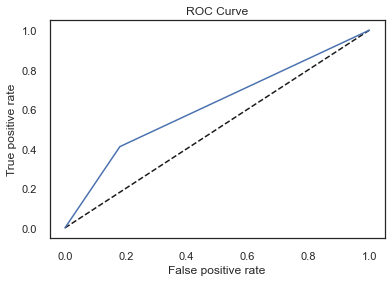

In [70]:
# Plot the ROC
fpr, tpr, _ = roc_curve(y_test,  dt.predict_proba(X_test)[:,1])
plot_roc(fpr, tpr)


**PROBLEM**: Use the `print_feature_importance()` function given to you above to print the relative feature importances of this model.

In [71]:
# Print feature importance

print_feature_importance(dt,X.columns)


  Feature        Importance
   PAY_1          0.1607 
    AGE           0.0729 
 BILL_AMT1        0.0688 
  PAY_AMT3        0.0610 
 LIMIT_BAL        0.0561 
 BILL_AMT2        0.0540 
  PAY_AMT6        0.0504 
 BILL_AMT6        0.0481 
  PAY_AMT5        0.0452 
  PAY_AMT1        0.0449 
 BILL_AMT5        0.0445 
 BILL_AMT3        0.0437 
 BILL_AMT4        0.0430 
  PAY_AMT2        0.0427 
   PAY_2          0.0347 
  PAY_AMT4        0.0337 
 EDUCATION        0.0224 
   PAY_6          0.0118 
   PAY_3          0.0113 
   PAY_5          0.0104 
   PAY_4          0.0103 
   SEX_1          0.0078 
   SEX_2          0.0070 
 MARRIAGE_2       0.0063 
 MARRIAGE_1       0.0057 
 MARRIAGE_3       0.0018 
 MARRIAGE_0       0.0008 


### Random Forests

Just one tree may be an arbitrary and unreliable model. So next, use the `RandomForestClassifier()` model from sklearn to run a random forest of trees and average across them.

**PROBLEM**: Build a pipeline for a random forest.

In [72]:
# Build pipeline
from sklearn.pipeline import Pipeline
estimator =[('RFC', RandomForestClassifier())]
pipeline=Pipeline(estimator)



**PROBLEM**: Tune for N, the number of trees and print out the results so you can find the best N.

In [80]:
# Tune N   

results = []
for N in range(1,100):
    pipeline.set_params(RFC__n_estimators=N) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_rft = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_rft, N)  )
# View results 
print('N'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, N) in results:
    print('{0:.4f}'.format(N).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

     N             AUC    
      1.0000      0.5938 
      2.0000      0.6412 
      3.0000      0.6830 
      4.0000      0.6972 
      5.0000      0.7123 
      6.0000      0.7252 
      7.0000      0.7140 
      8.0000      0.7265 
      9.0000      0.7202 
     10.0000      0.7291 
     11.0000      0.7347 
     12.0000      0.7363 
     13.0000      0.7436 
     14.0000      0.7411 
     15.0000      0.7407 
     16.0000      0.7402 
     17.0000      0.7470 
     18.0000      0.7446 
     19.0000      0.7422 
     20.0000      0.7475 
     21.0000      0.7497 
     22.0000      0.7598 
     23.0000      0.7587 
     24.0000      0.7500 
     25.0000      0.7484 
     26.0000      0.7536 
     27.0000      0.7521 
     28.0000      0.7498 
     29.0000      0.7551 
     30.0000      0.7524 
     31.0000      0.7537 
     32.0000      0.7648 
     33.0000      0.7551 
     34.0000      0.7538 
     35.0000      0.7565 
     36.0000      0.7532 
     37.0000      0.7607 
     38.000

In [81]:
#select tthe best N
pd.DataFrame(results,columns=['roc_auc','N'])[pd.DataFrame(results,columns=['roc_auc','N']).roc_auc==pd.DataFrame(results,columns=['roc_auc','N']).roc_auc.max()]


,roc_auc,N
84,0.772097,85


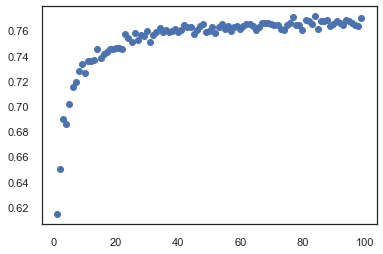

In [76]:
#plot auc_roc(N)
plt.scatter(x=pd.DataFrame(results,columns=['roc_auc','N'])['N'],y=pd.DataFrame(results,columns=['roc_auc','N'])['roc_auc'])

**PROBLEM**: Test the model and report the AUC. HINT: Make sure you are using the test sets every time you do a final test!

In [84]:
# Test final model
 
pipeline.set_params(RFC__n_estimators=85)
pipeline.fit(X_train,y_train)
y_prob_rfc = pipeline.predict_proba(X_test)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_prob_rfc[:, 1])
best_auc_rfc = roc_auc_score(y_test, y_prob_rfc[:,1])



**PROBLEM**: Plot the resulting ROC.

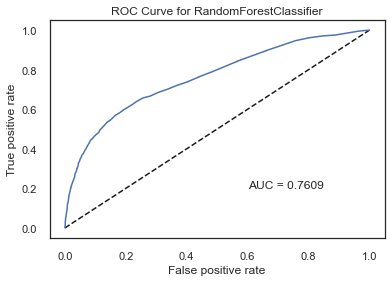

In [85]:
# Plot the ROC

plot_roc(fpr_rfc, tpr_rfc, 'ROC Curve for RandomForestClassifier', 'AUC = %2.4f' % best_auc_rfc)



**PROBLEM**: Use the `print_feature_importance()` function given to you above to print the relative feature importances of this model.

In [86]:
# Print feature importance


print_feature_importance(pipeline['RFC'],X.columns)


  Feature        Importance
   PAY_1          0.0940 
    AGE           0.0649 
 BILL_AMT1        0.0600 
 LIMIT_BAL        0.0599 
 BILL_AMT2        0.0534 
 BILL_AMT3        0.0512 
  PAY_AMT1        0.0499 
 BILL_AMT6        0.0498 
 BILL_AMT4        0.0494 
 BILL_AMT5        0.0487 
  PAY_AMT2        0.0473 
   PAY_2          0.0468 
  PAY_AMT6        0.0463 
  PAY_AMT3        0.0446 
  PAY_AMT4        0.0435 
  PAY_AMT5        0.0432 
   PAY_3          0.0281 
   PAY_4          0.0225 
   PAY_5          0.0209 
 EDUCATION        0.0198 
   PAY_6          0.0193 
   SEX_1          0.0087 
 MARRIAGE_2       0.0086 
   SEX_2          0.0086 
 MARRIAGE_1       0.0086 
 MARRIAGE_3       0.0016 
 MARRIAGE_0       0.0003 


# **PART 2**: Isolation Forests

In [87]:
%reset -f

The **Isolation Forest** is a decision tree method for anomaly detection.  

The isolation forest is an _unsupervised_ learning algorithm **based on the Decision Tree algorithm** that identifies an anomaly by isolating outliers in the data. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In general the first step to anomaly detection is to construct a profile of what is "normal", and then report anything that cannot be considered normal as anomalous. The isolation forest algorithm, however, does **not** work on that principle -- it does not define "normal" behavior or calculate point-based distances (such as a clustering approach). Instead, isolation forests recursively partition the *dataset* by randomly selecting a feature and then randomly selecting a split value for the feature. The main insight here is that anomalies (such as a case of fraud) should require fewer random partitions to be *isolated* from "normal" observations in the dataset because they are fundamentally different. Anomalies can therefore be identified as the points with a shorter-length path in the tree (path length being the number of edges traversed from the root node). Isolation forests not only detect anomalies faster but we also require less memory compared to other algorithms.

### **Setup**  

### Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Isolation forest
from sklearn.ensemble import IsolationForest

# plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings("ignore")

### Constants

In [2]:
# Set a seed for replication
SEED = 1

### Get Data

In [3]:
# Reading the data generated from previous notebook
data = pd.read_csv('data/data_simulated_fraud.csv', index_col=0)

data.head()

,salary,age,nb_siblings,fraud
Brandon Russell,2934.0,54.0,1,0
Steven Johnson,2387.0,32.0,1,0
Evelyn Christian,2731.0,54.0,2,0
George Cook,3471.0,54.0,1,0
Aaron Graham,1994.0,30.0,2,0


**PROBLEM**: Define and fit a basic (default) isolation forest model

In [4]:
# Define & fit the isolation forest model

model=IsolationForest().fit(data[['salary','age','nb_siblings']])


**PROBLEM**: Inspect the decision function (split points) for the model to confirm it did something!

In [5]:
data['scores']=model.decision_function(data[['salary','age','nb_siblings']])


**PROBLEM**: Use the model to predict anomalies

In [6]:
# Predict the anomalies
data['anomaly']=model.predict(data[['salary','age','nb_siblings']])
data.head(10)



,salary,age,nb_siblings,fraud,scores,anomaly
Brandon Russell,2934.0,54.0,1,0,0.041385,1
Steven Johnson,2387.0,32.0,1,0,0.081489,1
Evelyn Christian,2731.0,54.0,2,0,-0.029392,-1
George Cook,3471.0,54.0,1,0,-0.082662,-1
Aaron Graham,1994.0,30.0,2,0,0.046696,1
Kyle Jones,2772.0,46.0,0,0,0.045524,1
Jerome Whitehead,1903.0,30.0,2,0,0.031221,1
Charles Tyler,2678.0,42.0,2,0,0.057063,1
Thomas Berry,1617.0,40.0,2,0,-0.070614,-1
Ryan Mack,2098.0,38.0,0,0,0.015544,1


In [7]:
#outliers index
outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)

**PROBLEM**: Plot the results, differentiating colors between normal points and anomalies.

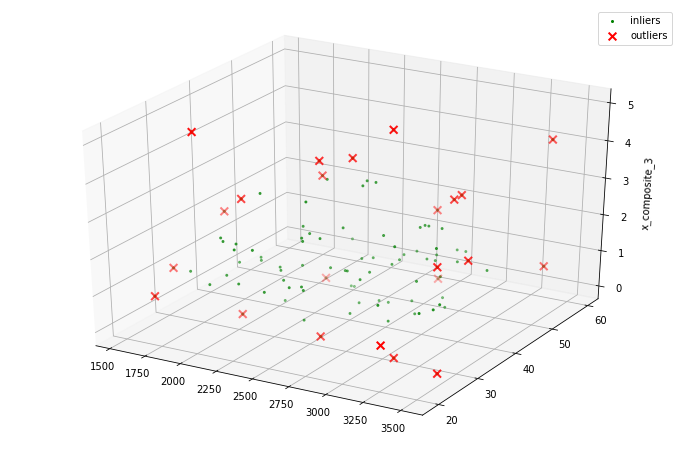

In [8]:
# Scatter plot with anomaly labelling from the isolation forest
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot data.iloc points
ax.scatter(data.iloc[:, 0].values, data.iloc[:, 1].values, zs=data.iloc[:, 2].values, s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(data.loc[outlier_index]['salary'].values,
           data.loc[outlier_index]['age'].values, 
           data.loc[outlier_index]['nb_siblings'].values,
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

**PROBLEM** **PROBLEM** **PROBLEM** **PROBLEM**: The above isolation forest used default fixed parameters. Let's optimize parameters by using a "grid search" and cross-validation. _HINT:_ You will need to limit the number of parameters and steps in the grid search to reduce the computational time. or it could take a very, very long time. (**Worth 4 points**)

In [9]:
#replace fraud=1 -> anomalies
data['fraud']=data['fraud'].replace({1:-1,0:1})

In [10]:
data['fraud']

Brandon Russell     1
Steven Johnson      1
Evelyn Christian    1
George Cook         1
Aaron Graham        1
                   ..
Beth Stevens       -1
Kristen Smith      -1
Donna Lewis        -1
Ashley Gallegos    -1
Leslie Nguyen      -1
Name: fraud, Length: 100, dtype: int64

In [160]:
f1sc = make_scorer(f1_score)

In [174]:
# Tune the isolation forest

#!!!!!!!!!Please do not run this cell (it took 0,5 day)


from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer


#Define parameters
parameters={'n_estimators': list(range(1, 100, 3)),
           'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5]}
              
f1sc = make_scorer(f1_score)

# Create a grid search object
clf = GridSearchCV(IsolationForest(), 
                   param_grid=parameters,cv=5,
                   scoring=f1sc,refit=True,return_train_score=True)

# Fit the grid search
clf.fit(data[['salary','age','nb_siblings']],data['fraud'])


GridSearchCV(cv=5, estimator=IsolationForest(),
             param_grid={'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_samples': [100, 105, 110, 115, 120, 125, 130, 135,
                                         140, 145, 150, 155, 160, 165, 170, 175,
                                         180, 185, 190, 195, 200, 205, 210, 215,
                                         220, 225, 230, 235, 240, 245, ...],
                         'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                          31, 34, 37, 40, 43, 46, 49, 52, 55,
                                          58, 61, 64, 67, 70, 73, 76, 79, 82,
                                          85, 88, ...]},
             return_train_score=True, scoring=make_scorer(f1_score))

In [177]:
clf_best=clf.best_estimator_

In [219]:
clf_best

IsolationForest(contamination=0.1, max_samples=425, n_estimators=16)

**PROBLEM**: Now predict again using your optimized model.

In [14]:
# Predict
model=IsolationForest(contamination=0.1, max_samples=425, n_estimators=16)
model.fit(data[['salary','age','nb_siblings']])
pred=model.predict(data[['salary','age','nb_siblings']])




In [15]:
#assign X and y
X=data[['salary','age','nb_siblings']]
y=data['fraud']

**PROBLEM**: Plot the results, differentiating colors between normal points and anomalies.

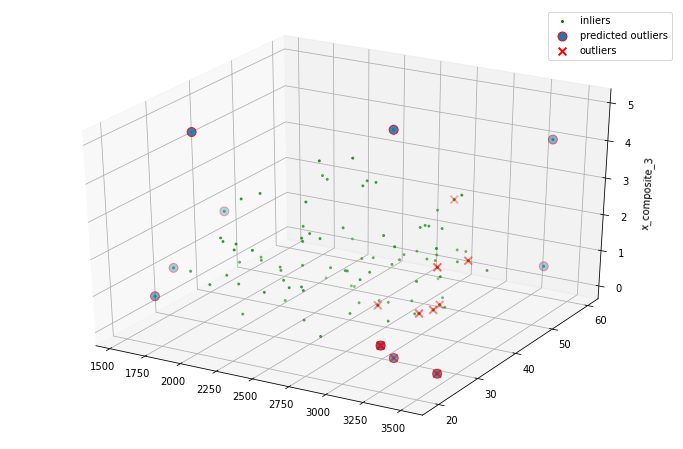

In [16]:
# Scatter plot with optimized parameters

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot data.iloc points
ax.scatter(data.iloc[:, 0].values, data.iloc[:, 1].values, zs=data.iloc[:, 2].values, s=4, 
           lw=1, c="green",label="inliers")


# Plot circles around the predicted outliers
ax.scatter(data.loc[pred == -1]['salary'].values,
           data.loc[pred == -1]['age'].values, 
           data.loc[pred == -1]['nb_siblings'].values,
           edgecolors="red", s=80, label="predicted outliers")


# Plot x's for the ground truth outliers
ax.scatter(data.loc[y == -1]['salary'].values,
           data.loc[y == -1]['age'].values, 
           data.loc[y == -1]['nb_siblings'].values,
           lw=2, s=60, marker="x", c="red", label="outliers")

plt.legend()
plt.show()






# **PART 3:** Artificial Neural Networks

In [ ]:
%reset -f

In the next sections of the assignment, you will classify images from the MNIST dataset (Source: http://yann.lecun.com/exdb/mnist/). The dataset includes hand written images and you need to predict the number (numerical digit) associated with each image. Every image has a dimension of 28 * 28 pixels and is gray-scale. The input data includes the intensity associated with each pixel row by row, starting from top-left corner (784 pixels in total). 

The label field shows the number associated with each image. 

A state-of-the-art model achieves an error rate of only 0.23% (Ciresan et al. CVPR 2012); you should be able to hit an error rate of less than 1% in this assignment. 

<img src="images/mnist_plot.png" width="352" height="280" align="center"/>

## SETUP

### Imports

Note that this assignment requires Tensorflow version 2. It must be version 2, as the Keras model in Tensorflow changed as of version 2. You can tensorflow with this pip command:

    pip install -U tensorflow
    
To track the progress of some of the longer-running processes in our solutions, we will also use the `tqdm` progressbar. If you wish to do so, you will have to install it

    pip install -U tqdm


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import itertools
import pickle
import random

from copy                    import deepcopy
from tqdm                    import tqdm
from scipy                   import ndimage

# Data science packages
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics         import confusion_matrix
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression

# Neural networks
import tensorflow as tf

# Visualization 
import seaborn as sns
import matplotlib.pyplot     as plt
import matplotlib.animation  as animation
from IPython.display         import HTML
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [70]:

# tf.keras

from tensorflow import keras

print(tf.__version__)



2.0.0-alpha0


### Constant Seed

In [2]:
# Set constant SEED for probabilistic functions for replicability
SEED = 12345

### Custom Functions

We again give you a few, custom, helper functions to get you going.

In [3]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.grid()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [4]:
def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

In [5]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean    = np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

## Preparation

**PROBLEM**: Load the image data into a pandas dataset. 

In [6]:
# Load data into a dataframe
"""mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
"""

'mnist = tf.keras.datasets.mnist\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\nx_train, x_test = x_train / 255.0, x_test / 255.0\n'

In [7]:
image_df =pd.read_csv('data/image_data.csv')

In [8]:
# View the top rows
image_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**PROBLEM**: Check the data. Is it complete? Right shape? Any problems or inconsistencies?

In [9]:
# Check the data and fix any problems
#Every image has a dimension of 28 * 28 pixels and is gray-scale. 
#The input data includes the intensity associated with each pixel row by row, 
#starting from top-left corner (784 pixels in total).

#The label field shows the number associated with each image. 
image_df.shape

(42000, 785)

In [10]:
image_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [11]:
#The data is 2 dimensional. In order to show a picture we can covert it to 3 dimensional data.
#reshape matrix
image_df_reshapes=np.array(image_df.loc[:,'pixel0':]).reshape((42000,28,28))

In [12]:
#shape of received matrix
image_df_reshapes.shape

(42000, 28, 28)

In [13]:
#check labels
image_df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

**PROBLEM**: Separate data into target variable and features.

In [14]:
# Separate features and target
y=image_df.label
X=image_df_reshapes


**PROBLEM**: Basic Feature Engineering.

In [15]:
# Normalize all features to be between 0 and 1
X_norm=X/ 255.0


In [16]:
image_df_norm=image_df.loc[:,'pixel0':]/255.0

**PROBLEM**: Inspect distribution of target.

In [17]:
# Check distribution of the labels (across numerical digits)

pd.Series(y).value_counts().sort_index()


0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

**PROBLEM**: Plot images 27, 83, and 158 in ONE dimension.  

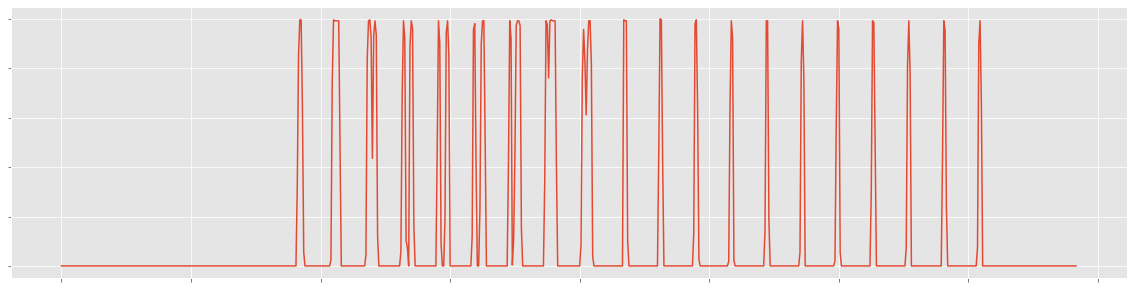

In [330]:
# Plot images 27, 83, and 158 in one dimension
plt.subplots(figsize=(20, 5))

image_df_norm.loc[27,'pixel0':].plot()
plt.show()


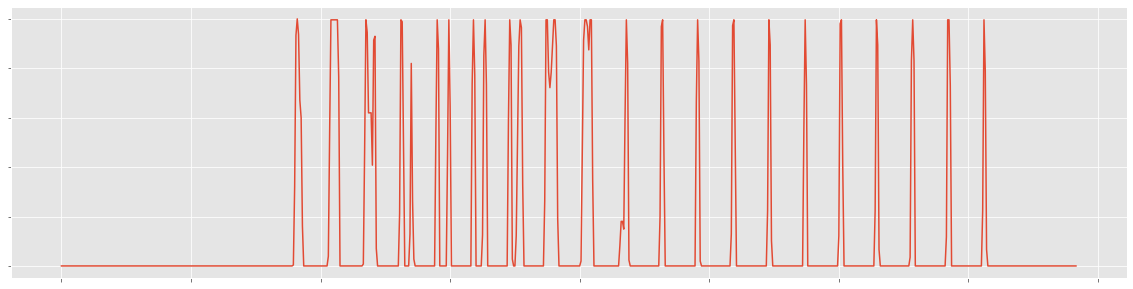

In [331]:
plt.subplots(figsize=(20, 5))
image_df_norm.loc[83,'pixel0':].plot()

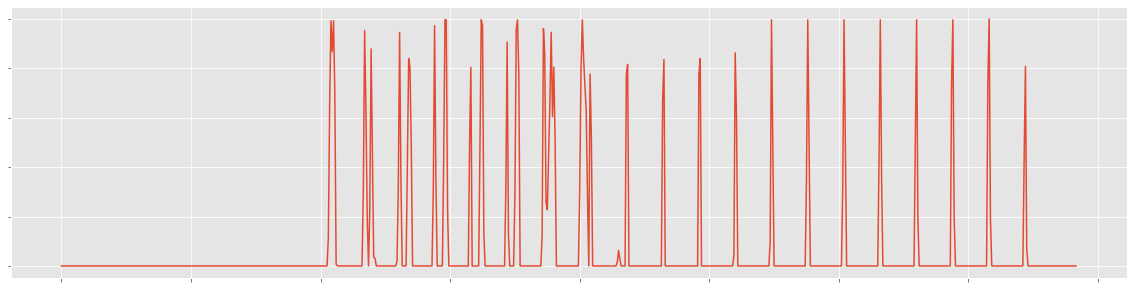

In [332]:
plt.subplots(figsize=(20, 5))
image_df_norm.loc[158,'pixel0':].plot()

**PROBLEM**: Plot images 27, 83, and 158 in TWO dimensions. Tip: use `plt.imshow()`

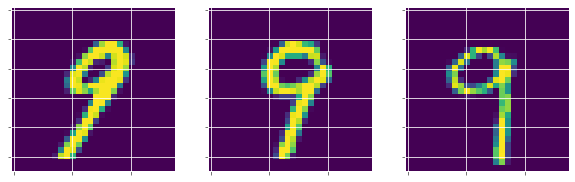

In [237]:
# Plot images 27, 83, and 158 in TWO dimensions

fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(X_norm[27,:,:])
ax[1].imshow(X_norm[83,:,:])
ax[2].imshow(X_norm[158,:,:])

**PROBLEM**: Create Training and Testing sets. Be sure to use SEED so our results and your results are comparable. 

In [254]:
# Create Training and Testing sets  
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=11) 



In [255]:
print('Mean: {}'.format(np.mean(y_train.value_counts().sort_index()/len(y_train))))
y_train.value_counts().sort_index()/len(y_train)

Mean: 0.09999999999999999


0    0.097721
1    0.112415
2    0.099898
3    0.102177
4    0.096429
5    0.092245
6    0.097075
7    0.105680
8    0.097007
9    0.099354
Name: label, dtype: float64

In [256]:
y_test.value_counts().sort_index()/len(y_test)

0    0.099921
1    0.109444
2    0.098413
3    0.106905
4    0.098175
5    0.085952
6    0.101825
7    0.102698
8    0.096111
9    0.100556
Name: label, dtype: float64

## Baseline Classifier

Before getting started on specific models, run a baseline classifier to set a benchmark for improved models.

**PROBLEM**: Use the `DummyClassifier()` model to make a baseline prediction.

In [260]:
# Define a baseline using DummyClassifier() and print the baseline accuracy. Remember to set the SEED!
from sklearn.metrics import accuracy_score

dummy=DummyClassifier(random_state=11)
dummy.fit(X_train,y_train)
y_pred=dummy.predict(X_test)
accuracy_score(y_test,y_pred)

0.10166666666666667

In [262]:
pd.Series(y_pred).value_counts().sort_index()/len(y_pred)

0    0.097222
1    0.113492
2    0.097460
3    0.099762
4    0.097460
5    0.096429
6    0.098413
7    0.106349
8    0.095873
9    0.097540
dtype: float64

In [263]:
np.mean(pd.Series(y_pred).value_counts().sort_index()/len(y_pred))

0.1

**QUESTION**: What was the baseline accuracy? Is that what you expected? Why or why not? 

**Answer**: 0.1017
Yes, it is as expected as proporion of classes is around 0,1



**QUESTION**: One might think that the baseline accuracy we received as technically impossible... Why would it have been impossible? Why was it in fact possible?  

**Answer**: It would have been impossible because the accuracy that we received is more than 10 % - the equiprobable probability to get a digit of 1-10.
It was possible because the model learned the probability for different digits in train dataset and predicted with these probability ( not equiprobable 0.1). For some digits probability is less than 10%, for some - more

**QUESTION**: What "strategy" parameter should you pass to `DummyClassifier()` and why? 

**Answer**: 

"stratified" to generate predictions by respecting the training set's class distribution



## Compare to Traditional Machine Learning Models

#### Regularized Logit Model

**PROBLEM** **PROBLEM** **PROBLEM** **PROBLEM**: Use a Ridge-Regularized Multinomial Logit Model to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter C, from logspace 10^-5 to 10^5, in steps of 1 in the exponent.
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across C.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.  
    
( **Worth 4 points**)

In [18]:

#split 2d data
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(image_df_norm, y, test_size=0.5, random_state=11) 

cv = StratifiedKFold(3)
np.random.seed(0)

# Define model
lr=LogisticRegression(penalty='l2',random_state=12)

# Now use the validation_curve() function to train/validate models...
train_scores, test_scores = validation_curve(lr, X_train_2d, y_train_2d, "C",
                                              param_range=np.logspace(-5,5,11),
                                              cv=cv,scoring="accuracy")






**PROBLEM**: Plot a validation curve across levels of C, using a logscale for the x axis.

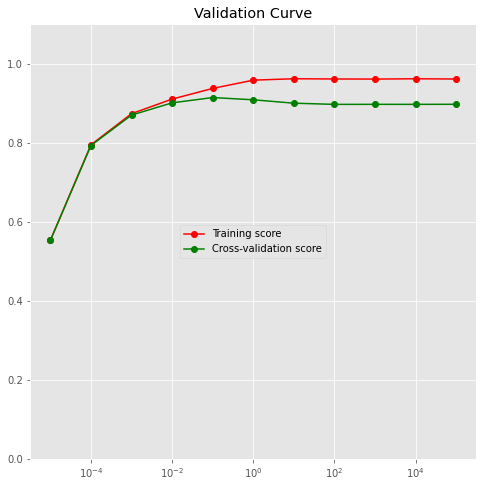

In [19]:
# Plot a validation curve  
fig, ax = plt.subplots(figsize=(8,8))
plot_validation_curve(train_scores,test_scores,np.logspace(-5,5,11),x_logscale=True)



**PROBLEM**: What was the best value of C?

In [20]:
# Obtain the best value of the hyper parameter
#0.1
params=np.logspace(-5,5,11)
np.argmax(test_scores.mean(axis=1)),np.max(test_scores.mean(axis=1))

(4, 0.9142380952380952)

In [21]:
params[4]

0.1

**QUESTION**: Should we believe this particular "optimal" value of C. Why or why not? 

In [22]:
# View cross validation scores

np.max(test_scores.mean(axis=1))


0.9142380952380952

In [23]:
test_scores.mean(axis=1)

array([0.55295238, 0.79295238, 0.86990476, 0.90090476, 0.9142381 ,
       0.90857143, 0.9       , 0.897     , 0.89709524, 0.89704762,
       0.8972381 ])

In [24]:
best_score=params[np.argmax(test_scores.mean(axis=1))]

In [25]:
train_scores

array([[0.55264286, 0.55085714, 0.55571429],
       [0.7945    , 0.79264286, 0.79714286],
       [0.87385714, 0.87164286, 0.87514286],
       [0.91142857, 0.91042857, 0.90907143],
       [0.94      , 0.93635714, 0.93564286],
       [0.9605    , 0.95614286, 0.95807143],
       [0.96307143, 0.96085714, 0.96157143],
       [0.96228571, 0.95964286, 0.96178571],
       [0.96228571, 0.95971429, 0.961     ],
       [0.96285714, 0.96064286, 0.96185714],
       [0.96371429, 0.95921429, 0.96042857]])

In [26]:
test_scores

array([[0.55142857, 0.55514286, 0.55228571],
       [0.79      , 0.79771429, 0.79114286],
       [0.86971429, 0.87314286, 0.86685714],
       [0.89985714, 0.90328571, 0.89957143],
       [0.91357143, 0.91614286, 0.913     ],
       [0.90642857, 0.91171429, 0.90757143],
       [0.89885714, 0.90328571, 0.89785714],
       [0.89514286, 0.90214286, 0.89371429],
       [0.89314286, 0.90314286, 0.895     ],
       [0.89342857, 0.90328571, 0.89442857],
       [0.89414286, 0.90214286, 0.89542857]])

**Answer**: 
No, because the "optimal" C does not have to have the highest score. 
One might want to select a lower C with a slightly lower score (0.90090476 for example) so Ridge will find a simpler model -- and simpler models are generally believed to generalize better, so it is best to error on the side of simplicity.


**QUESTION**: Comment on the performance of the Logit Model overall. Why did it (or did it not) perform well? Also comment on how regularization affected your results, and explain why regularization performed as it did. 

**Answer**: 
It peformed well (much better than dummy algorithm) because the distribution of the target outcome variable is  balanced.

The ridge regularization helped to prevent overfitting.
We see that train and validation converge before 0.01 and there is no overfitting and then train and validation diverge. This is because logit is beginning to overfit the training data, providing no generalizability to the model. However, because the cross validation score does not decrease significantly, the model is not suffering from high error due to variance.

**QUESTION**: Would these results survive manipulation of the underlying picture (for example, randonly shifting pictures left/right or rotating them). 

**Answer**: 
no



**PROBLEM**: What is the accuracy of the Logit Model on the __test set__ at the best value of C?

In [28]:
# Calculate Accuracy of Logit Model on the test set at best value of C
from sklearn.metrics import accuracy_score

lr_best=LogisticRegression(penalty='l2',random_state=12,C=best_score).fit(X_train_2d,y_train_2d)
y_pred_lr=lr_best.predict(X_test_2d)

accuracy_score(y_test_2d,y_pred_lr)

0.9170952380952381

## KNN Classifier

**PROBLEM**: Repeat the exercise above with a KNN Classifier to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter K from K=5 to K=45, in 5 point increments. 
  * Make sure to use the random state SEED, and remember that KNN will be slow to run...
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across K.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.

In [29]:
#use less data
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(image_df_norm, y, test_size=0.9, random_state=11)
# Use a KNN Classifier to predict labels

knn=KNeighborsClassifier(n_jobs=-1)



**PROBLEM**: Use the `validation_curve()` function to plot the Training and Cross-Validated results.

In [30]:
# Plot a validation curve across levels of K
np.random.seed(0)
cv = StratifiedKFold(3)
train_scores, test_scores = validation_curve(knn, X_train_2d, y_train_2d, "n_neighbors",
                                              param_range=np.arange(5,50,5),
                                              cv=cv,scoring="accuracy")



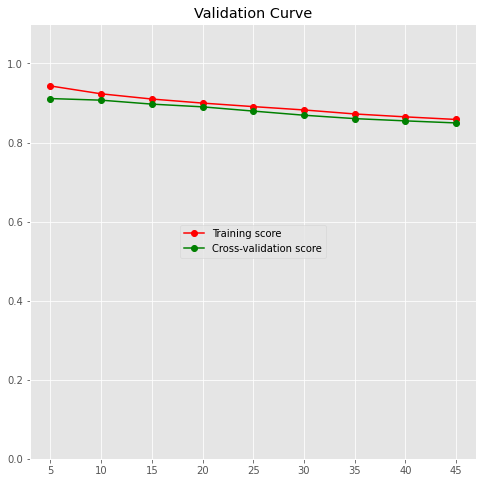

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
plot_validation_curve(train_scores,test_scores,np.arange(5,50,5))

**QUESTION**: Comment on and explain your results from the KNN Model. 

**Answer**: From this graph, we can observe that ‘k’ = 5 would be the ideal value of k. As the number of neighbours (k) increases, both the accuracy of Training Score as well as the cross-validation score decreases.

The higher k is the more data is included in a classification, creating more complex decision topologies, whereas the lower k is, the simpler the model is and the less it may generalize.




**PROBLEM**: What is the accuracy of the KNN Model on the __test set__ at the best value of K?

In [32]:
# Obtain the best value of the hyper parameter
k_params=np.arange(5,50,5)

#index and val score
print(np.argmax(test_scores.mean(axis=1)),np.max(test_scores.mean(axis=1)))

#best k
k_best_score=k_params[np.argmax(test_scores.mean(axis=1))]
print('Best value of K={}'.format(k_best_score))



0 0.9111904761904762
Best value of K=5


In [33]:
#make less data
X_train_2d_test, X_test_2d_test, y_train_2d_test, y_test_2d_test = train_test_split(X_test_2d, y_test_2d, test_size=0.1, random_state=11)
#fit data
#train data on data where we got k
knn_best=KNeighborsClassifier(n_neighbors=k_best_score).fit(X_train_2d,y_train_2d)
y_pred_knn=knn_best.predict(X_test_2d_test)


# Calculate Accuracy of KNN Model on the test set at best value of K
accuracy_score(y_test_2d_test,y_pred_knn)

0.9283068783068783

## Random Forest

**PROBLEM**: Repeat the exercise above with a Random Forest Classifier to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter K from K=5 to K=45, in 5 point increments. 
  * Make sure to use the random state SEED, and remember that KNN will be slow to run...
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across K.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.

In [34]:
# Use a Random Forest Classifier to predict labels


rfc=RandomForestClassifier()

**PROBLEM**: Use the `validation_curve()` function to plot the Training and Cross-Validated results.

In [49]:
#split data
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(image_df_norm, y, test_size=0.6, random_state=11)

# Plot a validation curve across Number of Estimators in Random Forest

np.random.seed(0)
cv = StratifiedKFold(3)
train_scores_rf, test_scores_rf = validation_curve(rfc, X_train_2d, y_train_2d, "n_estimators",
                                              param_range=np.arange(5,100,5),
                                              cv=cv,scoring="accuracy")


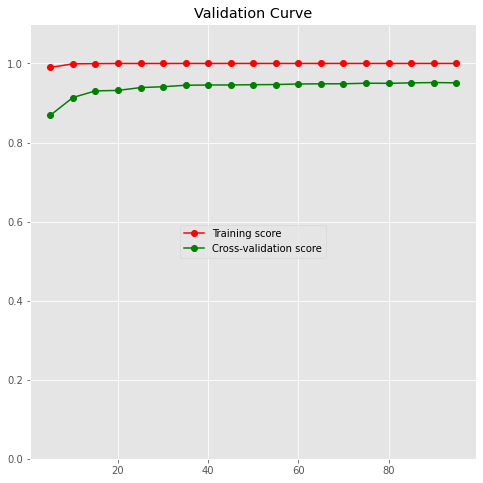

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
plot_validation_curve(train_scores_rf,test_scores_rf,np.arange(5,100,5))

**QUESTION**: Comment on and explain your results from the Random Forest Model. 

**Answer**: 
We can see the overfitting as accuracy on the train dataset is equal to 1 and accuracy on validation is much les

However, the accuracy on validation increase insignificantly by adding more trees to the RF model. And then, it stabilizes with more trees.
Thus, we can use simpler model (with less n_estimators) and get almost the same result

**QUESTION**: Comment on the behavior of the Training accuracy and the Cross-Validation accuracy in the Random Forest model for this problem. Explain why you think they performed (relatively) as they did. 

In [51]:
# Do some inspections...

train_scores_rf.mean(axis=1)


array([0.98997024, 0.99904762, 0.99955357, 0.99991071, 0.99994048,
       0.99991071, 1.        , 0.99997024, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [52]:
# Do some inspections...

test_scores_rf.mean(axis=1)


array([0.86904762, 0.91386905, 0.93059524, 0.93184524, 0.93892857,
       0.94113095, 0.94488095, 0.94547619, 0.94559524, 0.94625   ,
       0.94666667, 0.94809524, 0.94845238, 0.94857143, 0.95      ,
       0.9497619 , 0.95083333, 0.95172619, 0.95095238])

**Answer**: 
When we add more trees and average the answer of algorithms, the generalization error variance decreases. 

However, the bias of the generalization does not change.


**PROBLEM**: What is the accuracy of the Random Forest Model on the test set at the best value of N Estimators?

In [53]:
# Obtain the best value of the hyper parameter

#index of the best parameter, accuracy 
rf_params=np.arange(5,100,5)
print(np.argmax(test_scores_rf.mean(axis=1)),np.max(test_scores_rf.mean(axis=1)))

#Best value of n_estimators
rf_best_score=rf_params[np.argmax(test_scores_rf.mean(axis=1))]
print('Best value of n_estimators={}'.format(rf_best_score))

# Calculate Accuracy of Random Forest Model at best value of N Estimators

rft_best=RandomForestClassifier(n_estimators=rf_best_score).fit(X_train_2d,y_train_2d)
y_pred_rft=rft_best.predict(X_test_2d)

accuracy_score(y_test_2d,y_pred_rft)


17 0.9517261904761906
Best value of n_estimators=90


0.954920634920635

# PART 4: Convolutional Neural Networks (CNN) 

**PROBLEM**: Prepare data for a CNN. 

In [57]:
# Reshape image into 3 dimensions where third dimension is only 1 deep (so: height = 28px, width = 28px , canal = 1)

X_norm.shape


(42000, 28, 28)

In [65]:
# Encode target labels to one hot vectors

from sklearn.preprocessing import OneHotEncoder
y_one_hot=OneHotEncoder(categories = 'auto').fit_transform(y.values.reshape(-1,1))

In [69]:
#check onehot
y

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [100]:
y_one_hot=pd.DataFrame(y_one_hot.toarray())
y_one_hot

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
41995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**PROBLEM**: Print the value of some pixels from the new, reshaped array to show you can access the data. 

In [72]:
# Print first pixel in first observation
X_norm[1,1,1]


0.0

In [74]:
# Print last pixel in last observation

X_norm[-1,-1,-1]

0.0

In [75]:
# Print pixel from Observation 1234, horizontal offset 23, vertical offset 12
#sclaled pixel
X_norm[1234,23,12]


0.9921568627450981

In [78]:
#unscaled pixel
X[1234,23,12]

253

**PROBLEM**: Make a custom function to build and return a CNN object from TensorFlow.Keras (version 2). 

In [126]:
# Custom function to build and return a cnn model from TensorFlow.Keras (version 2)
def cnn_model():
    
    model =tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    

    return model

**PROBLEM**: Instantiate a model from your function above and print a diagram for it. 

In [127]:
# Instantiate a model from your function above and print a diagram for it.


model = cnn_model()


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [128]:
#split again the primary data to ensure
train_images, test_images,train_labels,  test_labels=train_test_split(X_norm,y,test_size=0.2,stratify=y)

In [129]:
train_labels

9002     6
29643    1
21407    1
370      2
13877    1
        ..
39979    8
18034    1
3138     1
41591    5
28174    3
Name: label, Length: 33600, dtype: int64

**PROBLEM**: Fit the model for 10 epochs and a batch size of 200, and then print a summary. _Tip:_ Be sure to use the reshaped training data.

In [130]:
# Further split the training set into a learning set and a validation set (do NOT stratify again -- that will break function and was already getting the training set)
train_images,val_images,train_labels,val_labels=train_test_split(train_images,train_labels,test_size=0.25)

# Fit the model and print a summary

model.fit(train_images, train_labels, epochs=10,batch_size=200)
model.summary()

Epoch 1/10
126/126 [==============================] - 0s 2ms/step - loss: 0.6049 - accuracy: 0.8368
Epoch 2/10
126/126 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.9264
Epoch 3/10
126/126 [==============================] - 0s 4ms/step - loss: 0.2071 - accuracy: 0.9423
Epoch 4/10
126/126 [==============================] - 0s 4ms/step - loss: 0.1708 - accuracy: 0.9528
Epoch 5/10
126/126 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9597
Epoch 6/10
126/126 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.9658
Epoch 7/10
126/126 [==============================] - 0s 2ms/step - loss: 0.1062 - accuracy: 0.9706
Epoch 8/10
126/126 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.9744
Epoch 9/10
126/126 [==============================] - 0s 3ms/step - loss: 0.0820 - accuracy: 0.9787
Epoch 10/10
126/126 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9806

**PROBLEM**: Evaluate the trained CNN model on the test set and print the loss score and accuracy score. 

In [132]:
%%capture
# Evaluate trained model on test set

predictions=model.predict_classes(test_images)

In [133]:
predictions

array([8, 1, 3, ..., 2, 3, 9])

In [134]:
# Print the loss and accuracy scores


accuracy_score(test_labels,predictions_single.round())

0.9598809523809524

**PROBLEM**: Get the predicted values and identify the correct cases/incorrect cases. 

In [ ]:
# Get predicted values
predicted_classes =  predictions
target_val_orig   =                # Get original (not one-hot-encoded) label
correct_indices   =                # Get index list of correctly predicted values
incorrect_indices =                # Get index list of incorrectly predicted values

**PROBLEM**: Print number of correctly and incorrectly clasified observations. 

In [ ]:
# Print number of correctly and incorrectly clasified observations



**PROBLEM**: Display 5 examples of incorrectly classified images. 

In [ ]:
# Display the first 5 examples of incorrectly classified images




**QUESTION**: Explain why you think the CNN made an error on those observations. 

**Answer**: 



**PROBLEM**: Predict and then use the plot the custom `plot_confusion_matrix()` function to plot the confustion matrix for all ten digits. 

In [ ]:
# Print the confustion matrix for all ten digits




# PART 5: Stress Your Data and Re-Run Models and Tests

This final part of this assignment is **open-ended...** 

Think of ways to distort, manipulate, and stress your training data (i.e., generate new images that can be added to your training data). After supplementing your dataset with the new images, re-run a Logit Model and a CNN model. Compare how the two models perform (relatively) given the new stressed training data. 

Explain what you find. 

**This is worth 25% of the entire assignment**, so be creative and thorough.